<a href="https://colab.research.google.com/github/wisnuajalah/Stock-Price/blob/main/Pengujian_20_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [93]:
from google.colab import drive

# mounting dataset dari gdrive
drive.mount('/content/gdrive', force_remount=True)

# folder ini juga digunakan untuk menyimpan model yang sudah dilatih
root_path = 'gdrive/My Drive/Colab Notebooks/Skripsi/'

# opsional - tampilkan info lokasi dataset
print("Path root:", root_path)

Mounted at /content/gdrive
Path root: gdrive/My Drive/Colab Notebooks/Skripsi/


In [94]:
# Import libraries
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import os

In [95]:
#Memuat data dari file CSV
file_path = root_path + "BRIS.JK.csv"
df = pd.read_csv(file_path, encoding='utf-8', sep=';')

# Menampilkan beberapa baris pertama data
print(df.head())

         Date         Open         High          Low        Close  \
0  09/05/2018  585.185.303  614.444.580  507.160.583  531.543.335   
1  10/05/2018          NaN          NaN          NaN          NaN   
2  11/05/2018  536.419.861  643.703.857  536.419.861  604.691.467   
3  14/05/2018  604.691.467  633.950.745  585.185.303  585.185.303   
4  15/05/2018  585.185.303  585.185.303  585.185.303  585.185.303   

     Adj Close  Adj_Close       Volume  
0  516.593.567      517.0  282154012.0  
1          NaN        NaN          NaN  
2  587.684.326      588.0  292500171.0  
3  568.726.868      569.0  127848119.0  
4  568.726.868      569.0          0.0  


In [96]:
# Cek data yang hilang
print(df.isnull().sum())

# Hapus baris dengan data yang hilang (jika diperlukan)
df.dropna(inplace=True)

Date         0
Open         1
High         1
Low          1
Close        1
Adj Close    1
Adj_Close    1
Volume       1
dtype: int64


In [97]:
# Menggunakan hanya kolom 'Adj_Close' untuk prediksi
#data = df['Adj_Close'].values.reshape(-1, 1)
#print(df['Adj_Close'])

In [98]:
# Memilih rentang waktu berdasarkan input dari user
tanggal_awal = input("Masukkan tanggal awal (format: YYYY-MM-DD): ")
tanggal_akhir = input("Masukkan tanggal akhir (format: YYYY-MM-DD): ")

# Filter dataframe berdasarkan tanggal yang dipilih
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')  # Specify the correct format for your dates
df_filtered = df[(df['Date'] >= tanggal_awal) & (df['Date'] <= tanggal_akhir)].copy()  # Use .copy() to avoid SettingWithCopyWarning

# Mengecek apakah data dalam rentang yang dipilih lebih dari 20 baris
if len(df_filtered) < 20:
    print(f"Data terlalu sedikit, hanya ada {len(df_filtered)} data dalam rentang waktu tersebut.")
else:
    # Mengambil 20 data terakhir dari rentang waktu yang dipilih
    test_data = df_filtered.tail(20)

    # Menggunakan hanya kolom 'Adj_Close' untuk prediksi
    data_test = test_data['Adj_Close'].values.reshape(-1, 1)

    # Menampilkan 20 data yang dipilih
    print(test_data[['Date', 'Adj_Close']])

Masukkan tanggal awal (format: YYYY-MM-DD): 2024-07-29
Masukkan tanggal akhir (format: YYYY-MM-DD): 2024-08-26
           Date  Adj_Close
1532 2024-07-30     2480.0
1533 2024-07-31     2600.0
1534 2024-08-01     2580.0
1535 2024-08-02     2550.0
1536 2024-08-05     2420.0
1537 2024-08-06     2500.0
1538 2024-08-07     2520.0
1539 2024-08-08     2520.0
1540 2024-08-09     2590.0
1541 2024-08-12     2600.0
1542 2024-08-13     2670.0
1543 2024-08-14     2660.0
1544 2024-08-15     2660.0
1545 2024-08-16     2620.0
1546 2024-08-19     2610.0
1547 2024-08-20     2640.0
1548 2024-08-21     2680.0
1549 2024-08-22     2620.0
1550 2024-08-23     2700.0
1551 2024-08-26     2730.0


In [99]:
# Normalisasi data untuk LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df_filtered['Adj_Close'].values.reshape(-1, 1))

In [100]:
# Membuat dataset untuk LSTM
def create_dataset(data, time_step):
    X, y = [], []
    for i in range(len(data) - time_step):
        a = data[i:(i + time_step), 0]
        X.append(a)
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

# Mengatur time_step
time_step = 10 if len(df_filtered) < 30 else 20  # Gunakan 5 jika data kurang dari 30
# Membuat dataset
X, y = create_dataset(scaled_data, time_step)

In [101]:
# Membagi data menjadi training dan testing
train_size = int(len(X) * 0.8)
X_train, X_test = X[0:train_size], X[train_size:len(X)]
y_train, y_test = y[0:train_size], y[train_size:len(y)]


In [102]:
# Mengubah data untuk dimasukkan ke dalam LSTM [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [103]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, activation='tanh', input_shape=(time_step, 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(units=25, activation='sigmoid'))
model.add(Dense(units=1, activation='sigmoid'))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [104]:
# Kompilasi model
optimizer1 = Adam(learning_rate=0.01)
optimizer2 = SGD(learning_rate=0.01)
optimizer3 = RMSprop(learning_rate=0.01)
model.compile(optimizer=optimizer1, loss='mean_squared_error')

In [105]:
# Menyimpan model terbaik selama pelatihan
checkpoint_filepath = 'best_model.keras'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

In [106]:
# Melatih model
history = model.fit(X_train, y_train, batch_size=16, epochs=100, validation_data=(X_test, y_test), callbacks=[model_checkpoint_callback])

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.0106 - val_loss: 0.0374
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 701ms/step - loss: 0.0081 - val_loss: 0.0300
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - loss: 0.0086 - val_loss: 0.0319
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 0.0085 - val_loss: 0.0366
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.0077 - val_loss: 0.0407
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 0.0080 - val_loss: 0.0426
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.0084 - val_loss: 0.0420
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - loss: 0.0081 - val_loss: 0.0407
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - loss: 0.0081 - val_loss: 0.0391
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: 0.0080 - val_loss: 0.0380
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.0081 - val_loss: 0.0372
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 0.0079 

In [107]:
# Melakukan prediksi
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step


In [108]:
# Mengembalikan skala data ke bentuk asli
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [109]:
# Mengembalikan skala y_train dan y_test ke bentuk asli
y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

In [110]:
# Menghitung Root Mean Squared Error (RMSE)
train_rmse = np.sqrt(mean_squared_error(y_train, train_predict))
test_rmse = np.sqrt(mean_squared_error(y_test, test_predict))

# Menghitung Mean Absolute Percentage Error (MAPE)
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

train_mape = mean_absolute_percentage_error(y_train[0], train_predict[:, 0])
test_mape = mean_absolute_percentage_error(y_test[0], test_predict[:, 0])

print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')
print(f'Train MAPE: {train_mape}')
print(f'Test MAPE: {test_mape}')


Train RMSE: 7.82333625248343
Test RMSE: 49.037488134925475
Train MAPE: 1.6812849778395433
Test MAPE: 1.8195744871183206


In [111]:
# Make sure that this is the correct path to your saved model
checkpoint_filepath = 'best_model.keras'
trained_model = load_model(checkpoint_filepath)

In [112]:
# Test the model
test_loss = trained_model.evaluate(X_test, y_test, verbose=1)
# Menghitung akurasi sebagai 100% - MAPE
test_accuracy = 100 - test_mape
print(f'Test MSE: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 7197993.5000
Test Loss: 7197993.5
Test Accuracy: 98.18042551288168


In [113]:
last_days = scaled_data[-time_step:]  # Mengambil dari nilai time_step
last_days = last_days.reshape(1, time_step, 1)  # Mengubah ke bentuk [samples, time steps, features]

# Melakukan prediksi untuk hari ke-61
predicted = model.predict(last_days)

# Mengembalikan prediksi ke skala asli
predicted = scaler.inverse_transform(predicted)

print(f'Prediksi Harga Hari ke-21: {predicted[0][0]}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediksi Harga Hari ke-21: 2667.6240234375


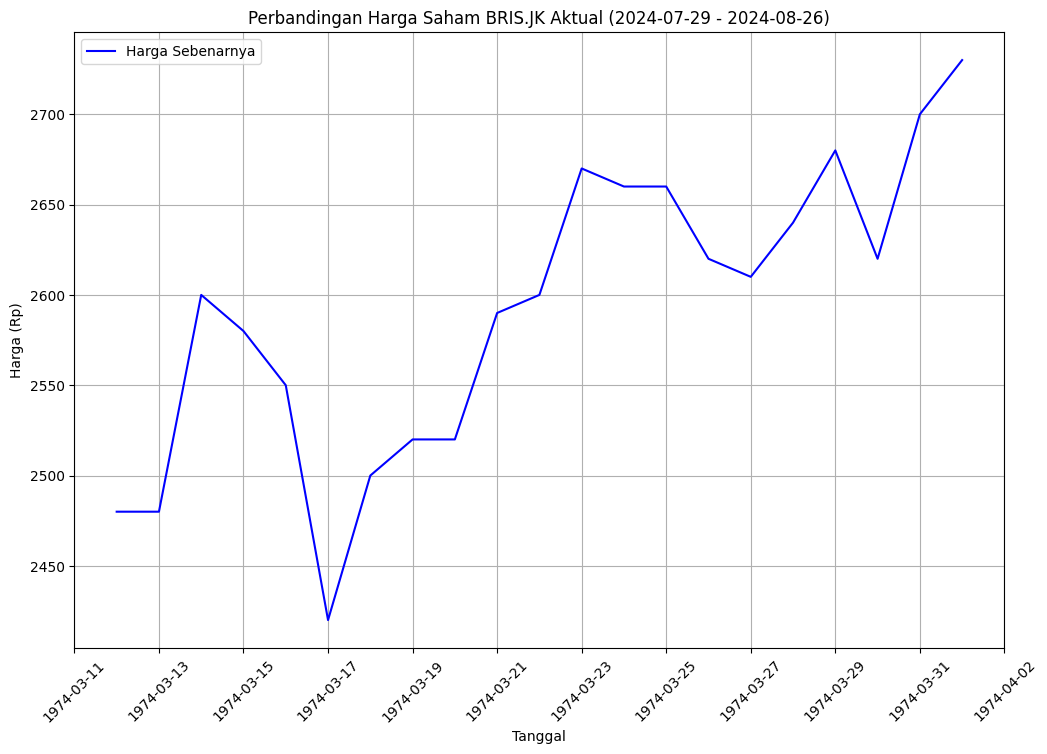

In [114]:
# Plot harga aktual dan prediksi
plt.figure(figsize=(12, 8))

# Plot harga aktual
plt.plot(df_filtered.index, df_filtered['Adj_Close'], label='Harga Sebenarnya', color='blue')

# Set label sumbu
plt.xlabel('Tanggal')
plt.ylabel('Harga (Rp)')

# Format tanggal pada sumbu x dengan harian
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))  # Menampilkan setiap 2 hari
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Format untuk tanggal

# Rotasi label tanggal
plt.xticks(rotation=45)

# Tambahkan judul dan grid
plt.title(f'Perbandingan Harga Saham BRIS.JK Aktual ({tanggal_awal} - {tanggal_akhir})')
plt.grid(True)

# Tambahkan legend
plt.legend()

# Tampilkan plot
plt.show()


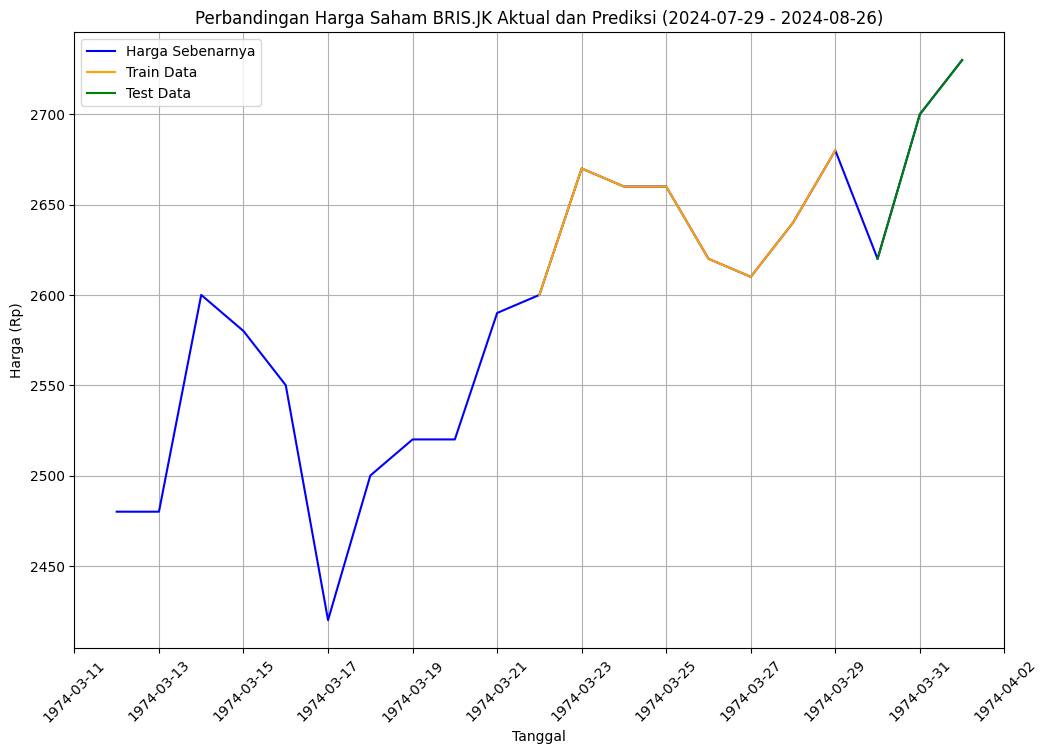

In [115]:

# Plot train and test data
plt.figure(figsize=(12, 8))

# Plot harga aktual
plt.plot(df_filtered.index, df_filtered['Adj_Close'], label='Harga Sebenarnya', color='blue')

# Plot train data, geser sebanyak time_step ke kanan
plt.plot(df_filtered.index[time_step:train_size + time_step], y_train, label='Train Data', color='orange')

# Plot test data
test_start_index = train_size + time_step  # Menghitung indeks awal untuk data test
plt.plot(df_filtered.index[test_start_index:test_start_index + len(y_test)], y_test.reshape(-1), label='Test Data', color='green')

# Set label sumbu
plt.xlabel('Tanggal')
plt.ylabel('Harga (Rp)')

# Format tanggal pada sumbu x dengan harian
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))  # Menampilkan setiap 2 hari
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Format untuk tanggal

# Rotasi label tanggal
plt.xticks(rotation=45)

# Tambahkan judul dan grid
plt.title(f'Perbandingan Harga Saham BRIS.JK Aktual dan Prediksi ({tanggal_awal} - {tanggal_akhir})')
plt.grid(True)

# Tambahkan legend
plt.legend()

# Tampilkan plot
plt.show()
